In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from collections import defaultdict

import scispacy
import spacy
from spacy import displacy
import en_ner_jnlpba_md
import en_core_sci_sm
import en_ner_bionlp13cg_md
import en_ner_bc5cdr_md
import random
from pathlib import Path

In [2]:
data_df = pd.read_csv('./datasets/mtsamples.csv').set_index(['index'])
data_df

,description,medical_specialty,sample_name,transcription,keywords
index,,,,,
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...
4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN


In [3]:
# combining all the strings together for cleaning
str_series = data_df['description']+data_df['medical_specialty']+data_df['sample_name']+data_df['transcription']
concat_df = pd.DataFrame({'med_str':str_series,'labels': data_df['keywords']})
concat_df

,med_str,labels
index,,
0,A 23-year-old white female presents with comp...,"allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass. Bari...,"bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass. Bari...,"bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler. Cardiovascular / Pulmo...,"cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram Cardiovascular / Pulmonary...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4994,Patient having severe sinusitis about two to ...,NaN
4995,This is a 14-month-old baby boy Caucasian who...,"allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,NaN


In [4]:
#checking for na values

concat_df.isna().sum()

med_str      33
labels     1068
dtype: int64

In [5]:
# dropping null values from combined list of medical strings

concat_df2 = concat_df.dropna(subset=['med_str'])

concat_df2

,med_str,labels
index,,
0,A 23-year-old white female presents with comp...,"allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass. Bari...,"bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass. Bari...,"bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler. Cardiovascular / Pulmo...,"cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram Cardiovascular / Pulmonary...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4994,Patient having severe sinusitis about two to ...,NaN
4995,This is a 14-month-old baby boy Caucasian who...,"allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,NaN


In [6]:
#checking for duplicates

concat_df2['med_str'].duplicated().sum()

0

In [7]:
#setting all to lower case

concat_df2['med_str'] = concat_df2['med_str'].apply(str.lower)

/Users/user_1/opt/anaconda3/envs/spacy36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
#checking for hyper links

display(concat_df2['med_str'].str.extract('(www\S+)').value_counts())
display(concat_df2['med_str'].str.extract('(http\S+)').value_counts())

Series([], dtype: int64)

Series([], dtype: int64)

In [9]:
#filter out punctuation

display(concat_df2['med_str'].str.extract(r'([^\w\s])').value_counts())

concat_df3 = concat_df2.copy()

concat_df3['med_str'] = concat_df2['med_str'].str.replace(r'([^\w\s])',' ')
concat_df3['med_str'] = concat_df3['med_str'].str.replace(r'(_)', ' ')


.    2153
,    1256
-    1154
(     150
/     100
:      46
&      46
'      22
#      18
;       7
%       5
+       4
"       4
?       1
dtype: int64

In [10]:
# filter out single digit numbers

display(concat_df3['med_str'].str.extract(r'(\d+)').value_counts())

concat_df4 = concat_df3.copy()

concat_df4['med_str'] = concat_df3['med_str'].str.replace('(\d+)','')

1        1238
2         478
3         295
4         247
5         240
         ... 
136         1
425         1
900         1
724         1
57307       1
Length: 162, dtype: int64

In [11]:
#filter out lone letters

concat_df5 = concat_df4.copy()

concat_df5['med_str'] = concat_df4['med_str'].str.replace(r'(\b[a-zA-Z]\b)','')

concat_df5

,med_str,labels
index,,
0,year old white female presents with complai...,"allergy / immunology, allergic rhinitis, aller..."
1,consult for laparoscopic gastric bypass bari...,"bariatrics, laparoscopic gastric bypass, weigh..."
2,consult for laparoscopic gastric bypass bari...,"bariatrics, laparoscopic gastric bypass, heart..."
3,mode doppler cardiovascular pulmonar...,"cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,echocardiogram cardiovascular pulmonary ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4994,patient having severe sinusitis about two to ...,NaN
4995,this is month old baby boy caucasian who ca...,"allergy / immunology, mucous membranes, conjun..."
4996,female for complete physical and follow up ...,NaN


In [12]:
# OPTIONAL

# def generate_dict(text_col):

#     '''Count number of words, sentences and generate a dictionary of all words'''

#     sent_count = 0
#     word_count = 0
#     vocab = defaultdict(lambda:0)
#     for text in text_col:
#         sentences=sent_tokenize(str(text).lower())
#         sent_count = sent_count + len(sentences)
#         for sentence in sentences:
#             words=word_tokenize(sentence)

#             for word in words:
#                 vocab[word]+=1

#     word_count = len(vocab.keys())
#     return sent_count,word_count,vocab

# sent_count,word_count,vocab= generate_dict(concat_df5['med_str'].tolist())

# display(sent_count,word_count,vocab)

In [13]:
# Extract our default stopwords from CountVectorizer

stop_words = CountVectorizer(stop_words= 'english').get_stop_words()

stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [14]:
#adding extra stop words

new_stop_words = []

for word in stop_words:
    new_stop_words.append(word)

new_stop_words.extend(['en','wa','ha'])

new_stop_words

['perhaps',
 'into',
 'amongst',
 'three',
 'sometime',
 'find',
 'must',
 'few',
 'after',
 'fifty',
 'more',
 'neither',
 'seemed',
 'was',
 'nor',
 'thick',
 'out',
 'being',
 'so',
 'herself',
 'bottom',
 'however',
 'of',
 'thence',
 'whoever',
 'me',
 'otherwise',
 'please',
 'thin',
 'what',
 'first',
 'is',
 'whereas',
 'behind',
 'hers',
 'afterwards',
 'and',
 'four',
 'cannot',
 'those',
 'by',
 'with',
 'other',
 'fire',
 'herein',
 'how',
 'do',
 'through',
 'here',
 'because',
 'less',
 'full',
 'before',
 'cry',
 'indeed',
 'latterly',
 'meanwhile',
 'across',
 'last',
 'co',
 'well',
 'to',
 'wherever',
 'itself',
 'twenty',
 'myself',
 'are',
 'show',
 'nine',
 'who',
 'himself',
 'i',
 'although',
 'under',
 'thereupon',
 'elsewhere',
 'both',
 'sincere',
 'often',
 'couldnt',
 'every',
 'from',
 'against',
 'anyhow',
 'besides',
 'hereby',
 'between',
 'mine',
 'one',
 'part',
 'done',
 'off',
 'while',
 'beside',
 'five',
 'throughout',
 'de',
 'put',
 'ever',
 'sys

In [15]:
#OPTIONAL

# # generating our vocab for all texts

# vocab_2 = [w for w in vocab.keys() if w not in new_stop_words]

# vocab_2

In [16]:
def lemmatize_sent(sent):

    '''Function for lemmatizing sentences and excluding stop words'''
    
    word_list = word_tokenize(sent)

    lemma = WordNetLemmatizer()

    lemma_list = ' '.join([lemma.lemmatize(w) for w in word_list if w not in new_stop_words])

    return lemma_list

In [17]:
# lemmatize sentences

concat_df6 = concat_df5.copy()
concat_df6['med_str'] = concat_df5['med_str'].map(lemmatize_sent)
concat_df6['med_str'][1]

'consult laparoscopic gastric bypass bariatrics laparoscopic gastric bypass consult past medical history difficulty climbing stair difficulty airline seat tying shoe used public seating lifting object floor exercise time week home doe cardio difficulty walking block flight stair difficulty snoring muscle joint pain including knee pain pain foot ankle pain swelling gastroesophageal reflux disease past surgical history includes reconstructive surgery right hand year ago social history currently single drink year smoked significantly month ago smoke cigarette day family history heart disease grandfather grandmother stroke grandmother diabetes denies obesity hypertension family member current medication allergy allergic penicillin miscellaneous eating history going support group seven month lynn holmberg greenwich eastchester new york feel appropriate program poor experience greenwich program eating history emotional eater doe like sweet like big portion carbohydrate like chicken steak cur

In [18]:
lemma_dict = {}

class StringTokenizer(object):

    '''This function is atcivated when we fit into cvec fit transform. it will create a lemma_dict'''

    def __init__(self):

        self.lem = WordNetLemmatizer()
        
    def __call__(self,object):

        for w in word_tokenize(object):

            lemma_dict[w] = self.lem.lemmatize(w)

        lemma_list = [self.lem.lemmatize(w) for w in word_tokenize(object)]
        
        return lemma_list

In [19]:
# # we want to generate lemmatize dictionary

# cvec = CountVectorizer(stop_words = new_stop_words,
# tokenizer = StringTokenizer(),)

# concat_cvec = pd.DataFrame(cvec.fit_transform(concat_df5['med_str']).todense(),columns = cvec.get_feature_names())

# concat_cvec.index.rename('index',inplace=True)

In [20]:
# initiating med spacy dictionaries

med_nlp = en_ner_bionlp13cg_md.load()

#nlp = spacy.load("en_ner_bionlp13cg_md")

#nlp = spacy.load("en_ner_jnlpba_md")
#nlp = en_ner_jnlpba_md.load()

In [33]:
def entity_table(df):

    ''' function to generate iob tagging and entity labelling'''

    i = 0

    temp_list = []

    for doc in med_nlp.pipe(df['med_str'].to_list()):

            list_ = [(df.index[i], x, x.ent_iob_, x.ent_type_) for x in doc]

            temp_list.append(pd.DataFrame(list_,columns = ['index','ent','iob tag', 'class']))

            i+=1

    table = pd.concat(temp_list)

    table.reset_index(drop=True,inplace=True)
            
    return table

# run the below if want to create tag table of cleaned data

#ent_table = entity_table(concat_df6[:])

#ent_table

In [34]:
# creating tag table on raw texts that have not been cleaned

ent_table_raw = entity_table(concat_df2[:50])

ent_table_raw

,index,ent,iob tag,class
0,0,,O,
1,0,a,O,
2,0,23-year-old,O,
3,0,white,O,
4,0,female,O,
...,...,...,...,...
22492,49,.,O,
22493,49,,O,
22494,49,no,O,
22495,49,deformities,O,


In [27]:
# joining transcriptions to entities classes after filtering out i and b tags

brat_ent_df = ent_table_raw[ent_table_raw['iob tag']!='O']
brat_table_df = brat_ent_df.join(data_df, how = 'left', on = 'index')

In [28]:
# creating group by object as we want to have count of each class label for each index
# for e.g., we want to find out which clinical note has the most simple chemical class labels

brat_groupby = brat_table_df.groupby(['index','class']).count()

In [38]:
# filtering out classes which we want to tag
# we want the indexes with the most tags of each class

brat_groupby2 = brat_groupby.reset_index()

class_list = ['SIMPLE_CHEMICAL', 'MULTI_TISSUE_STRUCTURE', 'ANATOMICAL_SYSTEM', 'ORGAN', 'CANCER', 'PATHOLOGICAL_FORMATION ']

brat_index = []

for c in class_list:

    for index in brat_groupby2[brat_groupby2['class']==c].sort_values('ent',ascending=False)[:20]['index'].tolist():
        if index not in brat_index:
            brat_index.append(index)

In [39]:
def save_annot_files(folder_path,doc,file_name):

        # saving annotations to local folder

        np.savetxt(folder_path+f'/{file_name}.ann', brat_table_2.values, fmt='%s', delimiter = '')

        # saving text file to local folder

        np.savetxt(folder_path+f'/{file_name}.txt',pd.Series(str(doc)), fmt='%s')

def save_config_files(folder_path, ent_labels):

        #creating unique labels

        unique_labels = list(set(ent_labels))

        unique_labels = [label.replace('\t','') for label in unique_labels]

        # saving entity labels to config file

        f = open(folder_path + '/annotation.conf','w')

        text = '[entities]\n' + '\n'.join(unique_labels)

        f.write(text)

        f.close()

In [40]:
def get_ents_now(brat_index,folder_path=None, ent_labels=None):

    '''This function prepares the data into dataframe format before saving them into files to be inserted into brat software'''

    for i in brat_index:

        # Creating dataframe format to put into brat

        doc = med_nlp(concat_df2['med_str'][i])

        brat_table = pd.DataFrame(doc.to_json()['ents'])

        if brat_table.empty:
            no_labels.append(i)
            continue

        brat_index = [int(i) for i in brat_index]

        doc = med_nlp(concat_df2['med_str'][i])

        brat_table['ents'] = ['\t'+ str(ent) for ent in doc.ents]
        brat_table['label'] = '\t'+ brat_table['label']

        brat_table['brat_tag'] = ['T' + str(i) for i in brat_table.index]
        brat_table['start'] = [' ' + str(i) for i in brat_table.start]
        brat_table['end'] = [' ' + str(i) for i in brat_table.end]

        brat_table_2 = brat_table[['brat_tag','label','start','end','ents']]

        labels_1 = brat_table_2['label'].values.tolist()

        #ent_labels is to get labels to store into config file

        ent_labels = ent_labels + labels_1

        # standardize file naming convention to index, specialty and sample

        index_name = str(i).zfill(4)
        specialty_name = data_df.loc[i,'medical_specialty']
        sample_name = data_df.loc[i,'sample_name']

        file_name = index_name + '_' + specialty_name +  '_' + sample_name
        file_name = file_name.replace(' ','_')
        file_name = file_name.replace("/",'_')

        print(brat_table_2)

    print(no_labels)

            # uncomment these if you want to save to files
            #save_annot_files(folder_path,doc,file_name)

        #save_config_files(folder_path,ent_labels)

#folder_path = '/Users/user_1/Desktop/brat_annotations'

ent_labels = []
no_labels = []

# filtering out only 3 indexes
brat_index_2 = brat_index[:1]

get_ents_now(brat_index_2,ent_labels = ent_labels)

   brat_tag                     label  start    end  \
0        T0                   \tORGAN     14     22   
1        T1                \tORGANISM     38     45   
2        T2         \tSIMPLE_CHEMICAL     69     76   
3        T3                  \tTISSUE    129    148   
4        T4                  \tCANCER    179    187   
5        T5  \tPATHOLOGICAL_FORMATION    257    274   
6        T6  \tPATHOLOGICAL_FORMATION    304    325   
7        T7                \tORGANISM    370    377   
8        T8         \tSIMPLE_CHEMICAL    401    408   
9        T9                  \tTISSUE    490    509   
10      T10                  \tCANCER    540    548   
11      T11         \tSIMPLE_CHEMICAL    649    674   
12      T12  \tMULTI_TISSUE_STRUCTURE    750    765   
13      T13         \tSIMPLE_CHEMICAL    909    917   
14      T14         \tSIMPLE_CHEMICAL    947    953   
15      T15      \tORGANISM_SUBSTANCE    974    986   
16      T16    \tORGANISM_SUBDIVISION   1022   1031   
17      T1

Text(0.5, 1.0, 'Entity Class Count')

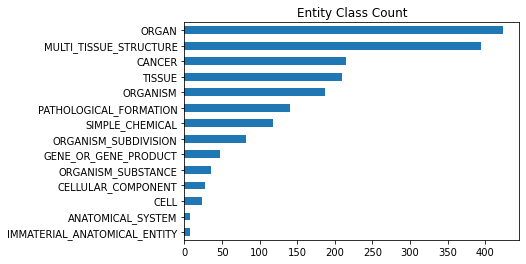

In [42]:
# checking count of classes

ent_table_raw['class'].value_counts()[1:].sort_values(ascending=True).plot(kind='barh')

plt.title('Entity Class Count')

Text(0.5, 1.0, 'Multi-Tissue-Top Entities')

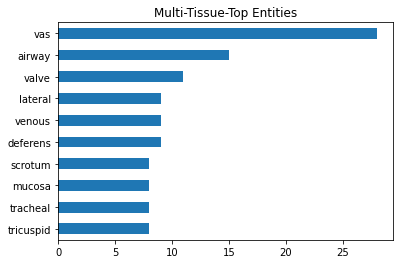

In [43]:
# Looking at the words which contribute to the top class 'MULTI_TISSUE_STRUCTURE'

multi_tissue_entity_s = ent_table_raw[ent_table_raw['class'] == 'MULTI_TISSUE_STRUCTURE']['ent'].astype('str')

multi_tissue_entity_s.value_counts().sort_values(ascending=True).tail(10).plot(kind='barh')

plt.title('Multi-Tissue-Top Entities')

In [45]:
def get_entity_options(ent_table,random_colors=False):
    """
    generating color options for visualizing the named entities
    """
    
    def color_generator(number_of_colors):
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
        return color

    entities = ent_table['class'].value_counts()[1:].index.tolist()
    
    colors = {"ENT":"#E8DAEF"}
    
    if random_colors:
        color = color_generator(len(entities))
        for i in range(len(entities)):
            colors[entities[i]] = color[i]
    else:
        entities_cat_1 = {"GGP":"#F9E79F", "SO":"#F7DC6F", "TAXON":"#F4D03F", "CHEBI":"#FAD7A0", "GO":"#F8C471", "CL":"#F5B041"}
        entities_cat_2 = {"DNA":"#82E0AA", "CELL_TYPE":"#AED6F1", "CELL_LINE":"#E8DAEF", "RNA":"#82E0AA", "PROTEIN":"#82E0AA"}
        entities_cat_3 = {"DISEASE":"#D7BDE2", "CHEMICAL":"#D2B4DE"}
        entities_cat_4 = {"CANCER":"#ABEBC6", "ORGAN":"#82E0AA", "TISSUE":"#A9DFBF", "ORGANISM":"#A2D9CE", "CELL":"#76D7C4", "AMINO_ACID":"#85C1E9", "GENE_OR_GENE_PRODUCT":"#AED6F1", "SIMPLE_CHEMICAL":"#76D7C4", "ANATOMICAL_SYSTEM":"#82E0AA", "IMMATERIAL_ANATOMICAL_ENTITY":"#A2D9CE", "MULTI-TISSUE_STRUCTURE":"#85C1E9", "DEVELOPING_ANATOMICAL_STRUCTURE":"#A9DFBF", "ORGANISM_SUBDIVISION":"#58D68D", "CELLULAR_COMPONENT":"#7FB3D5"}

        entities_cats = [entities_cat_1, entities_cat_2, entities_cat_3, entities_cat_4]
        for item in entities_cats:
            colors = {**colors, **item}
    
    options = {"ents": entities, "colors": colors}
    
    return options

get_entity_options(ent_table_raw)

{'ents': ['ORGAN',
  'MULTI_TISSUE_STRUCTURE',
  'CANCER',
  'TISSUE',
  'ORGANISM',
  'PATHOLOGICAL_FORMATION',
  'SIMPLE_CHEMICAL',
  'ORGANISM_SUBDIVISION',
  'GENE_OR_GENE_PRODUCT',
  'ORGANISM_SUBSTANCE',
  'CELLULAR_COMPONENT',
  'CELL',
  'IMMATERIAL_ANATOMICAL_ENTITY',
  'ANATOMICAL_SYSTEM'],
 'colors': {'ENT': '#E8DAEF',
  'GGP': '#F9E79F',
  'SO': '#F7DC6F',
  'TAXON': '#F4D03F',
  'CHEBI': '#FAD7A0',
  'GO': '#F8C471',
  'CL': '#F5B041',
  'DNA': '#82E0AA',
  'CELL_TYPE': '#AED6F1',
  'CELL_LINE': '#E8DAEF',
  'RNA': '#82E0AA',
  'PROTEIN': '#82E0AA',
  'DISEASE': '#D7BDE2',
  'CHEMICAL': '#D2B4DE',
  'CANCER': '#ABEBC6',
  'ORGAN': '#82E0AA',
  'TISSUE': '#A9DFBF',
  'ORGANISM': '#A2D9CE',
  'CELL': '#76D7C4',
  'AMINO_ACID': '#85C1E9',
  'GENE_OR_GENE_PRODUCT': '#AED6F1',
  'SIMPLE_CHEMICAL': '#76D7C4',
  'ANATOMICAL_SYSTEM': '#82E0AA',
  'IMMATERIAL_ANATOMICAL_ENTITY': '#A2D9CE',
  'MULTI-TISSUE_STRUCTURE': '#85C1E9',
  'DEVELOPING_ANATOMICAL_STRUCTURE': '#A9DFBF',
  'ORG

In [47]:
# fit string into medspacy and display it

doc = med_nlp(concat_df6['med_str'][6])

options = get_entity_options(ent_table_raw)

displacy.render(doc, style='ent', options=options)

In [50]:
# below is a sample of how u can insert lines into txt files

# f = open('/Users/user_1/Desktop/a_2.txt','r')

# contents = f.readlines()

# f.close()

# contents.insert(2,'a\n')

# f = open('/Users/user_1/Desktop/a_2.txt','w')

# contents = ''.join(contents)

# f.write(contents)

# f.close()

In [51]:
# amend this index according to the files which have been annotated

annotated_index = [40,43,110,149,173,226,257,319]

# folder_path is the path where the extracted brat files that have been man labelled are from

folder_path = '/Users/user_1/Desktop/brat_extracted/brat_annotations'

def generate_annotation_csv(annotated_index,folder_path):

    '''This function extracts labelling data from the annotated brat files, stores them into a df and outputs a csv'''

    extract_index = [str(x).zfill(4) for x in annotated_index]

    concat_list = []

    files = Path(folder_path).glob('*')

    # looping through files to match file name and check if it is an annotation file

    for file in files:

        file_num = file.name[:4]
        
        if file_num in extract_index:

            if file.name[-3:] == 'ann':
                with open(file) as f:
                    lines = f.readlines()

                    print(file.name)

                # transforming annotation file to store into df

                transf_1 = [x.replace("\t"," ") for x in lines]
                transf_2 = [x.replace("\n"," ") for x in transf_1]
                transf_3 = [x.split(' ',4) for x in [x.strip() for x in transf_2]]

                df_1 = pd.DataFrame(transf_3)

                df_1.columns = ['tag_index','class','start','end','entity']

                df_1['index'] = file_num

                concat_list.append(df_1)

    labelled_df = pd.concat(concat_list)

    return labelled_df

# generating df for extracting man labelled data

man_labelled_df = generate_annotation_csv(annotated_index,folder_path)

man_labelled_df

#man_labelled_df.to_csv('man_labelled_df.csv', header = True, index=False)

0319__Surgery__Suboccipital_Craniectomy__.ann
0110__Urology__Hysterectomy,_BSO,_&_Appendectomy._.ann
0173__Urology__Bladder_Biopsies_&_Fulguration_.ann
0149__Urology__Cystoprostatectomy_.ann
0257__Surgery__Total_Hip_Arthroplasty_.ann
0040__Urology__TURBT_.ann
0043__Urology__Salvage_Cystectomy_.ann
0226__Surgery__TURBT_.ann


,tag_index,class,start,end,entity,index
0,T0,CANCER,49,54,tumor,0319
1,T2,ORGANISM,297,304,patient,0319
2,T3,CANCER,334,341,neuroma,0319
3,T4,ORGANISM,348,355,patient,0319
4,T5,IMMATERIAL_ANATOMICAL_ENTITY,412,443,cerebellar peduncle compression,0319
...,...,...,...,...,...,...
42,T46,PROCEDURE,681,691,cystoscopy,0226
43,T14,DIAGNOSIS,794,817,coronary artery disease,0226
44,T15,PROCEDURE,901,916,tumor resection,0226
45,T47,PROCEDURE,1035,1045,cystoscopy,0226


In [62]:
#generating df for extracting spacey labelled data

annotated_index = [40,43,110,149,173,226,257,319]

folder_path = '/Users/user_1/Desktop/brat_annotations'

spacy_labelled_df = generate_annotation_csv(annotated_index,folder_path)

#spacy_labelled_df.to_csv('spacy_labelled_df.csv', header = True, index=False)

0319__Surgery__Suboccipital_Craniectomy__.ann
0110__Urology__Hysterectomy,_BSO,_&_Appendectomy._.ann
0173__Urology__Bladder_Biopsies_&_Fulguration_.ann
0149__Urology__Cystoprostatectomy_.ann
0257__Surgery__Total_Hip_Arthroplasty_.ann
0040__Urology__TURBT_.ann
0043__Urology__Salvage_Cystectomy_.ann
0226__Surgery__TURBT_.ann
